In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive to access data files
drive.mount("/content/gdrive")

# Load or generate your training data (assuming `input.data` is available as a 34x2 matrix).
# The data file should contain two columns where:
#   - The first column represents X values (input features),
#   - The second column represents Y values (target outputs).
data = np.loadtxt('/content/gdrive/MyDrive/data/input.data')  # Load data from Google Drive

X_train = data[:, 0].reshape(-1, 1)  # Extract X values and reshape to a column vector
Y_train = data[:, 1].reshape(-1, 1)  # Extract Y values and reshape to a column vector

# Rational Quadratic Kernel function
def rq_kernel(X1, X2, sigma_f=1.0, length_scale=1.0, alpha=1.0):
    """
    Computes the Rational Quadratic (RQ) kernel between two sets of points, X1 and X2.

    Args:
        X1 (np.ndarray): First input set of points (N x D).
        X2 (np.ndarray): Second input set of points (M x D).
        sigma_f (float): Kernel amplitude parameter.
        length_scale (float): Length scale parameter.
        alpha (float): Controls the relative weighting of the polynomial component in the kernel.

    Returns:
        np.ndarray: RQ kernel matrix (N x M).
    """
    # Calculate the squared distance between each pair of points in X1 and X2
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    # Apply the Rational Quadratic kernel formula
    return sigma_f**2 * (1 + sqdist / (2 * alpha * length_scale**2))**(-alpha)

# Compute covariance matrix with an added noise term
def compute_covariance_matrix(X, kernel, params=None):
    """
    Computes the covariance matrix for input data X using the specified kernel function.

    Args:
        X (np.ndarray): Input data points (N x D).
        kernel (function): Kernel function to calculate the covariance.
        params (dict): Dictionary of kernel parameters.

    Returns:
        np.ndarray: Covariance matrix (N x N) with noise term.
    """
    # Calculate the covariance matrix using the kernel function
    K = kernel(X, X, **params)
    return K

# Gaussian Process Prediction
def gp_predict(X_train, Y_train, X_test, kernel, params):
    """
    Makes predictions for new points X_test using a Gaussian Process with a given kernel.

    Args:
        X_train (np.ndarray): Training input data.
        Y_train (np.ndarray): Training output data.
        X_test (np.ndarray): Test input data.
        kernel (function): Kernel function to calculate the covariance.
        params (dict): Dictionary of kernel parameters.

    Returns:
        tuple: Mean (predicted values) and variance of predictions.
    """
    sigma_n = 1/5  # Assumes noise variance is (1/beta)

    # Compute covariance matrices
    K = compute_covariance_matrix(X_train, kernel, params=params)  # Training covariance
    K_s = kernel(X_train, X_test, **params)  # Cross-covariance between train and test points
    K_ss = kernel(X_test, X_test, **params) + sigma_n * np.eye(len(X_test))  # Test covariance with noise

    # Compute the inverse of the training covariance matrix with noise
    K_inv = np.linalg.inv(K + sigma_n * np.eye(len(K)))

    # Calculate the predictive mean and covariance for test points
    mu_s = K_s.T @ K_inv @ Y_train  # Predictive mean
    cov_s = K_ss - K_s.T @ K_inv @ K_s  # Predictive covariance

    return mu_s.flatten(), np.diag(cov_s)  # Return mean and variance as 1D arrays

# Negative log marginal likelihood (NLML)
def nlml(params, X_train, Y_train, kernel):
    """
    Calculates the Negative Log Marginal Likelihood (NLML) for a Gaussian Process.

    Args:
        params (list): List of kernel parameters [sigma_f, length_scale, alpha].
        X_train (np.ndarray): Training input data.
        Y_train (np.ndarray): Training output data.
        kernel (function): Kernel function to calculate the covariance.

    Returns:
        float: NLML value as a scalar.
    """
    # Unpack the kernel parameters into a dictionary
    params_dict = {'sigma_f': params[0], 'length_scale': params[1], 'alpha': params[2]}

    # Compute the covariance matrix for the training data
    K = compute_covariance_matrix(X_train, kernel, params=params_dict)

    # Attempt to compute the inverse of K; if it's not invertible, return infinity
    try:
        K_inv = np.linalg.inv(K)
    except np.linalg.LinAlgError:
        return np.inf  # Return a large value if K is not invertible

    # Calculate the log marginal likelihood using the formula
    log_likelihood = (
        0.5 * Y_train.T @ K_inv @ Y_train +
        0.5 * np.log(np.linalg.det(K)) +
        len(X_train) / 2 * np.log(2 * np.pi)
    )
    return log_likelihood.item()  # Return as a scalar


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


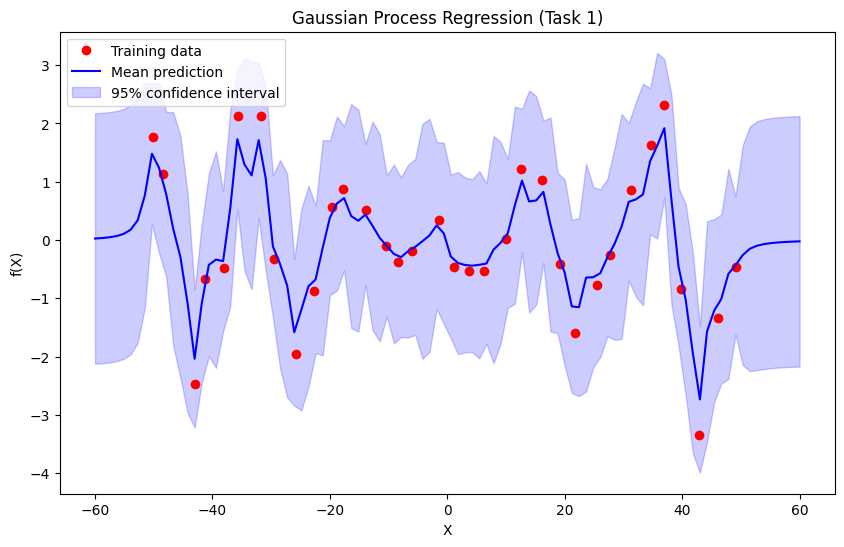

In [ ]:
# Task 1: GP Regression and Visualization

# Define test input range for predictions
X_test = np.linspace(-60, 60, 100).reshape(-1, 1)  # Generate 100 points from -60 to 60 for testing

# Set initial kernel parameters for Gaussian Process
initial_params = {'sigma_f': 1.0, 'length_scale': 1.0, 'alpha': 1.0}

# Perform Gaussian Process prediction using training data and test points
mu_s, var_s = gp_predict(X_train, Y_train, X_test, rq_kernel, initial_params)

# Visualization of Gaussian Process Regression results
plt.figure(figsize=(10, 6))

# Plot training data as red dots
plt.plot(X_train, Y_train, 'ro', label="Training data")

# Plot the mean prediction for test points as a blue line
plt.plot(X_test, mu_s, 'b-', label="Mean prediction")

# Shade the 95% confidence interval around the mean prediction
# 1.96 * sqrt(var_s) gives the interval for approximately 95% confidence in a Gaussian distribution
plt.fill_between(
    X_test.flatten(),
    mu_s - 1.96 * np.sqrt(var_s),
    mu_s + 1.96 * np.sqrt(var_s),
    color='blue',
    alpha=0.2,
    label="95% confidence interval"
)

# Add labels, legend, and title
plt.legend()
plt.xlabel("X")  # Label for X-axis
plt.ylabel("f(X)")  # Label for Y-axis
plt.title("Gaussian Process Regression (Task 1)")

# Display the plot
plt.show()


Optimized parameters: sigma_f=1.372305078539857, length_scale=2.4761180674252894, alpha=8.49149413156042


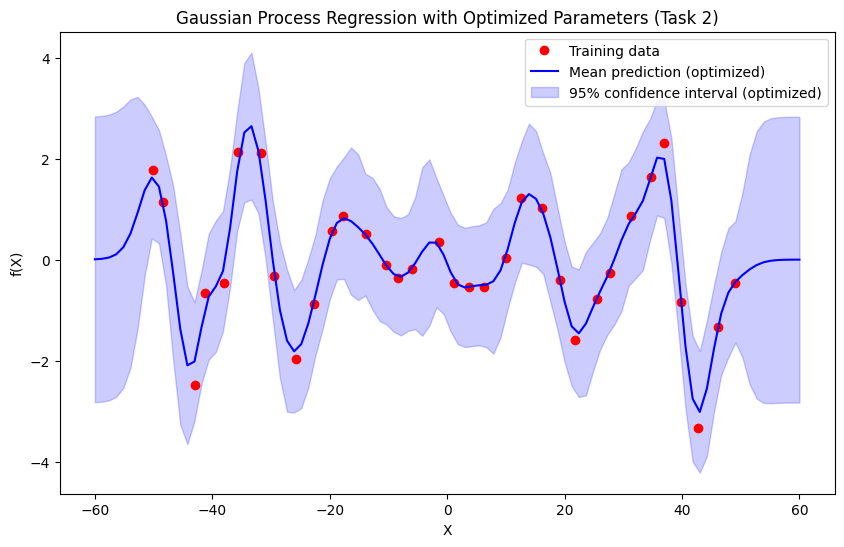

In [ ]:
# Task 2: Optimize kernel parameters by minimizing NLML
from scipy.optimize import minimize

# Initial guess for the kernel parameters: sigma_f, length_scale, alpha
# These initial values are used as the starting point for the optimization process.
initial_params_values = [1.0, 1.0, 1.0]

# Perform the optimization using the 'minimize' function from SciPy.
# The function nlml computes the negative log marginal likelihood (NLML) based on the kernel parameters.
# args=(X_train, Y_train, rq_kernel) passes the training data and kernel function to nlml.
# bounds=((1e-5, 1e5), (1e-5, 1e5), (1e-5, 1e5)) specifies that the kernel parameters should be constrained to reasonable positive values.
optimized_result = minimize(nlml, initial_params_values, args=(X_train, Y_train, rq_kernel), bounds=((1e-5, 1e5), (1e-5, 1e5), (1e-5, 1e5)))

# Retrieve the optimized parameters (sigma_f, length_scale, and alpha) from the result of the optimization
optimized_params = optimized_result.x

# Print out the optimized kernel parameters for verification
print(f"Optimized parameters: sigma_f={optimized_params[0]}, length_scale={optimized_params[1]}, alpha={optimized_params[2]}")

# Visualization for Task 2 with optimized parameters
# Use the optimized kernel parameters to predict the mean and variance of the test points
# Create a dictionary with the optimized parameters to pass to the gp_predict function
optimized_params_dict = {'sigma_f': optimized_params[0], 'length_scale': optimized_params[1], 'alpha': optimized_params[2]}

# Predict the mean (mu_s_optimized) and variance (var_s_optimized) using the optimized parameters
mu_s_optimized, var_s_optimized = gp_predict(X_train, Y_train, X_test, rq_kernel, optimized_params_dict)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot the training data (X_train, Y_train) as red circles
plt.plot(X_train, Y_train, 'ro', label="Training data")

# Plot the mean prediction for the test data (X_test) using the optimized kernel parameters
plt.plot(X_test, mu_s_optimized, 'b-', label="Mean prediction (optimized)")

# Plot the 95% confidence interval for the prediction, which is the mean ± 1.96 * standard deviation
plt.fill_between(X_test.flatten(), mu_s_optimized - 1.96 * np.sqrt(var_s_optimized), mu_s_optimized + 1.96 * np.sqrt(var_s_optimized), color='blue', alpha=0.2, label="95% confidence interval (optimized)")

# Add labels and a title for the plot
plt.legend()
plt.xlabel("X")
plt.ylabel("f(X)")
plt.title("Gaussian Process Regression with Optimized Parameters (Task 2)")

# Show the plot
plt.show()


II. SVM on MNIST dataset

In [ ]:
import libsvm
from libsvm.svmutil import *
import matplotlib.pyplot as plt

X_train = np.loadtxt('/content/gdrive/MyDrive/data/X_train.csv', delimiter=',')
Y_train = np.loadtxt('/content/gdrive/MyDrive/data/Y_train.csv', delimiter=',')
X_test = np.loadtxt('/content/gdrive/MyDrive/data/X_test.csv', delimiter=',')
Y_test = np.loadtxt('/content/gdrive/MyDrive/data/Y_test.csv', delimiter=',')

Training with linear kernel...
Accuracy = 95.08% (2377/2500) (classification)
Classification results using linear kernel:
Class 1.0: Correct Count = 489, Total = 500, Accuracy = 97.80%
Class 2.0: Correct Count = 491, Total = 500, Accuracy = 98.20%
Class 3.0: Correct Count = 453, Total = 500, Accuracy = 90.60%
Class 4.0: Correct Count = 454, Total = 500, Accuracy = 90.80%
Class 5.0: Correct Count = 490, Total = 500, Accuracy = 98.00%
Overall Accuracy: 95.08 %
Training with polynomial kernel...
Accuracy = 34.68% (867/2500) (classification)
Classification results using polynomial kernel:
Class 1.0: Correct Count = 214, Total = 500, Accuracy = 42.80%
Class 2.0: Correct Count = 500, Total = 500, Accuracy = 100.00%
Class 3.0: Correct Count = 47, Total = 500, Accuracy = 9.40%
Class 4.0: Correct Count = 47, Total = 500, Accuracy = 9.40%
Class 5.0: Correct Count = 59, Total = 500, Accuracy = 11.80%
Overall Accuracy: 34.68 %
Training with rbf kernel...
Accuracy = 95.24% (2381/2500) (classificati

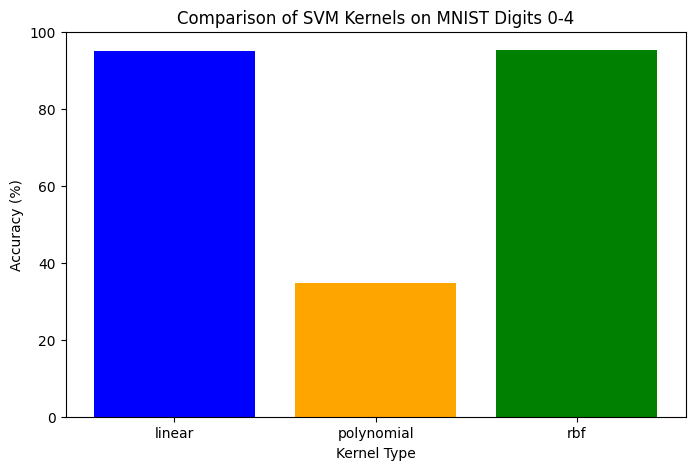

In [ ]:

# Function to train and evaluate the SVM model
def train_and_evaluate_svm(X_train, Y_train, X_test, Y_test, kernel_type, degree=3, gamma='scale'):

    # Set SVM kernel parameter based on the chosen kernel type
    # The '-t' option specifies the type of kernel:
    # 0 = linear, 1 = polynomial, 2 = radial basis function (RBF)
    if kernel_type == 'linear':
        # For a linear kernel, set '-t 0'
        svm_param = '-t 0'
    elif kernel_type == 'polynomial':
        # For a polynomial kernel, set '-t 1' and specify the degree of the polynomial kernel (default degree=3)
        svm_param = f'-t 1 -d {degree}'
    elif kernel_type == 'rbf':
        # For an RBF kernel, set '-t 2' and specify the gamma parameter (default gamma='scale')
        # If gamma is 'scale', use a default value of 0.001
        svm_param = '-t 2 -g ' + (gamma if gamma != 'scale' else '0.001')
    else:
        # Raise an error if an invalid kernel type is provided
        raise ValueError("Invalid kernel type. Please choose 'linear', 'polynomial', or 'rbf'.")

    # Train the SVM model using the training data (X_train, Y_train)
    # Convert data to list format as required by libsvm
    model = svm_train(Y_train, X_train.tolist(), svm_param)

    # Predict on the test data (X_test) and evaluate accuracy
    # p_labels contains the predicted labels, p_acc contains accuracy metrics, p_vals contains decision function values
    p_labels, p_acc, p_vals = svm_predict(Y_test, X_test.tolist(), model)
    accuracy = p_acc[0]  # Extract overall accuracy from p_acc

    # Output statistics for each class
    # Create dictionaries to store correct and total counts for each class in the test set
    correct_counts = {label: 0 for label in np.unique(Y_test)}
    total_counts = {label: 0 for label in np.unique(Y_test)}

    # Loop through each test sample to update the correct and total counts for each class
    for true_label, pred_label in zip(Y_test, p_labels):
        total_counts[true_label] += 1  # Increment the total count for the true label
        if true_label == pred_label:
            correct_counts[true_label] += 1  # Increment the correct count if prediction matches the true label

    # Print the classification results for each class
    print(f"Classification results using {kernel_type} kernel:")
    for label in correct_counts:
        # Output the correct count, total count, and accuracy for each class
        print(f"Class {label}: Correct Count = {correct_counts[label]}, Total = {total_counts[label]}, Accuracy = {100 * correct_counts[label] / total_counts[label]:.2f}%")

    # Print overall accuracy of the model
    print("Overall Accuracy:", accuracy, "%")

    return accuracy, p_labels  # Return the accuracy and predicted labels for further use

# Train and compare the performance of different kernels
kernels = ['linear', 'polynomial', 'rbf']  # List of kernel types to compare
accuracies = []  # List to store the accuracies for each kernel

# Loop through the different kernels and evaluate their performance
for kernel in kernels:
    print(f"Training with {kernel} kernel...")
    # Call the function to train the model and evaluate accuracy
    accuracy, _ = train_and_evaluate_svm(X_train, Y_train, X_test, Y_test, kernel_type=kernel)
    accuracies.append(accuracy)  # Store the accuracy for this kernel

# Visualization of results
# Create a bar chart to compare the accuracies of different kernels
plt.figure(figsize=(8, 5))
plt.bar(kernels, accuracies, color=['blue', 'orange', 'green'])  # Plot the accuracies as bars
plt.xlabel('Kernel Type')  # Label for the x-axis
plt.ylabel('Accuracy (%)')  # Label for the y-axis
plt.title('Comparison of SVM Kernels on MNIST Digits 0-4')  # Title of the plot
plt.show()  # Display the plot


Compare with the different degree of polynomial kernel

Training with rbf kernel...
Accuracy = 94.8% (2370/2500) (classification)
Classification results using polynomial kernel:
Class 1.0: Correct Count = 482, Total = 500, Accuracy = 96.40%
Class 2.0: Correct Count = 490, Total = 500, Accuracy = 98.00%
Class 3.0: Correct Count = 452, Total = 500, Accuracy = 90.40%
Class 4.0: Correct Count = 453, Total = 500, Accuracy = 90.60%
Class 5.0: Correct Count = 493, Total = 500, Accuracy = 98.60%
Overall Accuracy: 94.8 %
Training with rbf kernel...
Accuracy = 88.24% (2206/2500) (classification)
Classification results using polynomial kernel:
Class 1.0: Correct Count = 453, Total = 500, Accuracy = 90.60%
Class 2.0: Correct Count = 497, Total = 500, Accuracy = 99.40%
Class 3.0: Correct Count = 382, Total = 500, Accuracy = 76.40%
Class 4.0: Correct Count = 401, Total = 500, Accuracy = 80.20%
Class 5.0: Correct Count = 473, Total = 500, Accuracy = 94.60%
Overall Accuracy: 88.24 %
Training with rbf kernel...
Accuracy = 34.68% (867/2500) (classification)


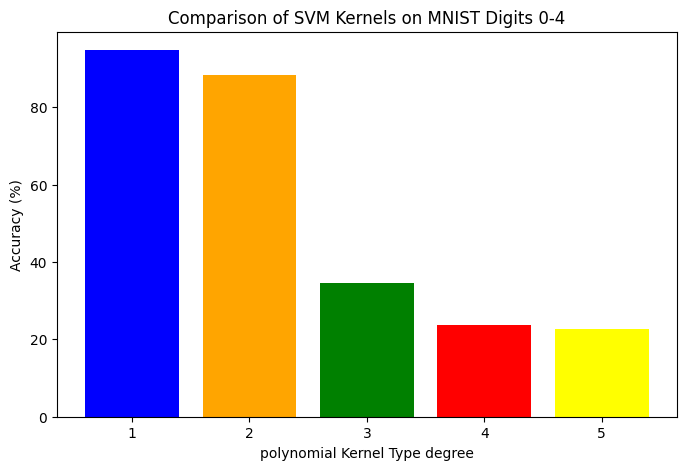

In [ ]:
# Function to train and evaluate the SVM model
def train_and_evaluate_svm(X_train, Y_train, X_test, Y_test, kernel_type, degree, gamma='scale'):

    # Set SVM kernel parameter based on the chosen kernel type
    # The '-t' option specifies the type of kernel:
    # 0 = linear, 1 = polynomial, 2 = radial basis function (RBF)
    if kernel_type == 'linear':
        # For a linear kernel, set '-t 0'
        svm_param = '-t 0'
    elif kernel_type == 'polynomial':
        # For a polynomial kernel, set '-t 1' and specify the degree of the polynomial kernel (default degree=3)
        svm_param = f'-t 1 -d {degree}'
    elif kernel_type == 'rbf':
        # For an RBF kernel, set '-t 2' and specify the gamma parameter (default gamma='scale')
        # If gamma is 'scale', use a default value of 0.001
        svm_param = '-t 2 -g ' + (gamma if gamma != 'scale' else '0.001')
    else:
        # Raise an error if an invalid kernel type is provided
        raise ValueError("Invalid kernel type. Please choose 'linear', 'polynomial', or 'rbf'.")

    # Train the SVM model using the training data (X_train, Y_train)
    # Convert data to list format as required by libsvm
    model = svm_train(Y_train, X_train.tolist(), svm_param)

    # Predict on the test data (X_test) and evaluate accuracy
    # p_labels contains the predicted labels, p_acc contains accuracy metrics, p_vals contains decision function values
    p_labels, p_acc, p_vals = svm_predict(Y_test, X_test.tolist(), model)
    accuracy = p_acc[0]  # Extract overall accuracy from p_acc

    # Output statistics for each class
    # Create dictionaries to store correct and total counts for each class in the test set
    correct_counts = {label: 0 for label in np.unique(Y_test)}
    total_counts = {label: 0 for label in np.unique(Y_test)}

    # Loop through each test sample to update the correct and total counts for each class
    for true_label, pred_label in zip(Y_test, p_labels):
        total_counts[true_label] += 1  # Increment the total count for the true label
        if true_label == pred_label:
            correct_counts[true_label] += 1  # Increment the correct count if prediction matches the true label

    # Print the classification results for each class
    print(f"Classification results using {kernel_type} kernel:")
    for label in correct_counts:
        # Output the correct count, total count, and accuracy for each class
        print(f"Class {label}: Correct Count = {correct_counts[label]}, Total = {total_counts[label]}, Accuracy = {100 * correct_counts[label] / total_counts[label]:.2f}%")

    # Print overall accuracy of the model
    print("Overall Accuracy:", accuracy, "%")

    return accuracy, p_labels  # Return the accuracy and predicted labels for further use


# Train and compare the performance of different kernels
kernels = ['polynomial']  # List of kernel types to compare
accuracies = []  # List to store the accuracies for each kernel
degree = [1,2,3,4,5]
# Loop through the different kernels and evaluate their performance
for deg in degree:
    print(f"Training with {kernel} kernel...")
    # Call the function to train the model and evaluate accuracy
    accuracy, _ = train_and_evaluate_svm(X_train, Y_train, X_test, Y_test, 'polynomial', deg, gamma='scale')
    accuracies.append(accuracy)  # Store the accuracy for this kernel

# Visualization of results
# Create a bar chart to compare the accuracies of different kernels
plt.figure(figsize=(8, 5))
plt.bar(degree, accuracies, color=['blue', 'orange', 'green', "red", "yellow"])  # Plot the accuracies as bars
plt.xlabel('polynomial Kernel Type degree')  # Label for the x-axis
plt.ylabel('Accuracy (%)')  # Label for the y-axis
plt.title('Comparison of SVM Kernels on MNIST Digits 0-4')  # Title of the plot
plt.show()  # Display the plot

Accuracy = 92.84% (2321/2500) (classification)
Accuracy for training with C=0.1, gamma=scale: 92.84%
Accuracy = 82.68% (2067/2500) (classification)
Accuracy for training with C=0.1, gamma=auto: 82.68%
Accuracy = 50.88% (1272/2500) (classification)
Accuracy for training with C=0.1, gamma=0.1: 50.88%
Accuracy = 20.08% (502/2500) (classification)
Accuracy for training with C=0.1, gamma=1: 20.08%
Accuracy = 78.64% (1966/2500) (classification)
Accuracy for training with C=0.1, gamma=10: 78.64%
Accuracy = 95.32% (2383/2500) (classification)
Accuracy for training with C=1, gamma=scale: 95.32%
Accuracy = 93.8% (2345/2500) (classification)
Accuracy for training with C=1, gamma=auto: 93.80%
Accuracy = 90.4% (2260/2500) (classification)
Accuracy for training with C=1, gamma=0.1: 90.40%
Accuracy = 30.04% (751/2500) (classification)
Accuracy for training with C=1, gamma=1: 30.04%
Accuracy = 20.24% (506/2500) (classification)
Accuracy for training with C=1, gamma=10: 20.24%
Accuracy = 96.28% (2407/2

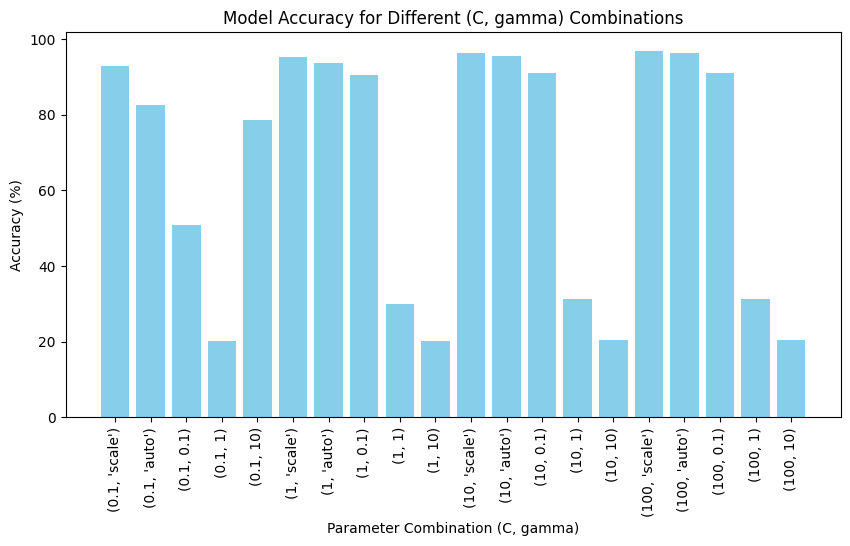

In [ ]:
import numpy as np
from libsvm.svmutil import *
import matplotlib.pyplot as plt

# Hyperparameter range for grid search: 'C' values and 'gamma' values to test
C_values = [0.1, 1, 10, 100]  # Regularization parameter values
gamma_values = ['scale', 'auto', 0.1, 1, 10]  # Kernel coefficient values for 'rbf' kernel

# Initialize variables to store the best result
best_accuracy = 0  # Variable to store the best accuracy found
best_C = None  # Store the best C value
best_gamma = None  # Store the best gamma value
best_model = None  # Store the best trained model

# List to store the accuracy for each (C, gamma) combination
accuracies = []

# Perform grid search over all combinations of 'C' and 'gamma' values
for C in C_values:
    for gamma in gamma_values:
        # Set gamma value based on the chosen setting
        # If gamma is 'scale', set gamma to 1 / number of features in the training set
        if gamma == 'scale':
            gamma_value = 1 / X_train.shape[1]  # Standard SVM scaling of gamma
        # If gamma is 'auto', set gamma to 1 / number of samples in the training set
        elif gamma == 'auto':
            gamma_value = 1 / X_train.shape[0]  # Auto setting for gamma in libsvm
        else:
            # If gamma is a numeric value, use it directly
            gamma_value = gamma

        # Set SVM parameters for training with radial basis function (RBF) kernel (-t 2 for RBF)
        svm_param = f'-t 2 -c {C} -g {gamma_value}'

        # Train the model using the current C and gamma values
        model = svm_train(Y_train.tolist(), X_train.tolist(), svm_param)

        # Predict the labels on the test set and calculate the accuracy
        p_labels, p_acc, p_vals = svm_predict(Y_test.tolist(), X_test.tolist(), model)

        accuracy = p_acc[0]  # Extract the accuracy percentage from the prediction results
        print(f"Accuracy for training with C={C}, gamma={gamma}: {accuracy:.2f}%")  # Output the current accuracy

        # Append the accuracy for the current combination of parameters
        accuracies.append(accuracy)

        # If the current accuracy is the best, update the best parameters and model
        if accuracy > best_accuracy:
            best_accuracy = accuracy  # Update the best accuracy
            best_C = C  # Update the best C value
            best_gamma = gamma  # Update the best gamma value
            best_model = model  # Update the best model

# Output the best result found during grid search
print(f"\nBest Result: C={best_C}, gamma={best_gamma}, Accuracy={best_accuracy:.2f}%")

# Predict using the best model and calculate the classification report and confusion matrix
best_labels, _, _ = svm_predict(Y_test.tolist(), X_test.tolist(), best_model)

# Ensure the confusion matrix has the correct dimensions to handle all possible label values
num_classes = len(np.unique(np.concatenate((Y_test, best_labels))))  # Get the total number of unique classes
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)  # Initialize a zero matrix for the confusion matrix

# Compute the confusion matrix by comparing true and predicted labels
for true_label, pred_label in zip(Y_test, best_labels):
    true_label = int(true_label)  # Convert the true label to an integer
    pred_label = int(pred_label)  # Convert the predicted label to an integer
    conf_matrix[true_label - 1, pred_label - 1] += 1  # Update the matrix with the count of predictions

# Output the classification report: the number of correct predictions and accuracy for each class
print("\nClassification Report:")
for i, label in enumerate(np.unique(Y_test)):  # Loop through each unique class in the test set
    correct = conf_matrix[i, i]  # Correct predictions for this class
    total = np.sum(conf_matrix[i, :])  # Total instances for this class
    accuracy = (correct / total) * 100 if total > 0 else 0  # Calculate the accuracy for this class
    print(f"Class {label}: Correct Count = {correct}, Total = {total}, Accuracy = {accuracy:.2f}%")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)  # Output the confusion matrix showing true vs. predicted labels

# Visualize the accuracy for each (C, gamma) combination in a bar chart
best_params = [(C, gamma) for C in C_values for gamma in gamma_values]  # List of (C, gamma) combinations

# Create a bar chart to visualize the accuracy for each parameter combination
plt.figure(figsize=(10, 5))  # Set the figure size for the plot
plt.bar([str(param) for param in best_params], accuracies, color='skyblue')  # Plot the accuracy values
plt.xlabel('Parameter Combination (C, gamma)')  # Label for the x-axis
plt.ylabel('Accuracy (%)')  # Label for the y-axis
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.title('Model Accuracy for Different (C, gamma) Combinations')  # Title of the plot
plt.show()  # Display the plot


**When we combine two kernel functions, such as a linear kernel and a radial basis function (RBF) kernel, their sum forms a new valid kernel.**

In [ ]:
import numpy as np
from libsvm.svmutil import *  # Importing necessary functions from libsvm for SVM

# Define a custom kernel function that combines linear and RBF (Radial Basis Function) kernels
def linear_rbf_kernel(X, Y, gamma=0.5):
    """
    A custom kernel that combines linear and RBF kernels.
    Linear part: dot product of input matrices.
    RBF part: Gaussian kernel computed using the Euclidean distance.

    Parameters:
    - X: Training data matrix.
    - Y: Test data matrix.
    - gamma: Hyperparameter for the RBF kernel.

    Returns:
    - The computed kernel matrix.
    """
    # Compute linear kernel (dot product between X and Y)
    linear_part = np.dot(X, Y.T)

    # Compute RBF kernel using the Euclidean distance between data points
    rbf_part = np.exp(-gamma * np.linalg.norm(X[:, None] - Y, axis=2) ** 2)

    # Combine linear and RBF kernels
    return linear_part + rbf_part

# Function to compute the kernel matrix in batches for efficiency
def batch_kernel_matrix(X1, X2, batch_size, gamma=0.5):
    """
    Compute the kernel matrix between two datasets in batches to manage memory and computation.

    Parameters:
    - X1: First dataset (e.g., training data).
    - X2: Second dataset (e.g., testing data).
    - batch_size: The size of each batch to process at a time.
    - gamma: Hyperparameter for the RBF kernel.

    Returns:
    - The computed kernel matrix.
    """
    n1 = X1.shape[0]  # Number of samples in X1
    n2 = X2.shape[0]  # Number of samples in X2

    kernel_matrix = np.zeros((n1, n2))  # Initialize an empty kernel matrix

    # Loop over X1 in batches
    for i in range(0, n1, batch_size):
        end_i = min(i + batch_size, n1)  # Get the batch slice for X1
        batch_X1 = X1[i:end_i]

        # Loop over X2 in batches
        for j in range(0, n2, batch_size):
            end_j = min(j + batch_size, n2)  # Get the batch slice for X2
            batch_X2 = X2[j:end_j]

            # Compute the kernel for the current batch and store it
            kernel_matrix[i:end_i, j:end_j] = linear_rbf_kernel(batch_X1, batch_X2, gamma)

    return kernel_matrix

# Function to train and evaluate SVM using a custom kernel
def train_and_evaluate_custom_kernel(X_train, Y_train, X_test, Y_test, gamma=0.5, batch_size=100):
    """
    Train and evaluate an SVM model using a custom kernel (linear + RBF),
    computed in batches for efficiency.

    Parameters:
    - X_train: Training data features.
    - Y_train: Training data labels.
    - X_test: Test data features.
    - Y_test: Test data labels.
    - gamma: Hyperparameter for the RBF kernel.
    - batch_size: The size of each batch to process at a time.

    Returns:
    - accuracy: The accuracy of the model on the test set.
    - Y_pred: The predicted labels for the test set.
    """
    # Construct the training kernel matrix using batches
    K_train = batch_kernel_matrix(X_train, X_train, batch_size, gamma)
    # Convert the kernel matrix to the format expected by libsvm
    K_train = np.hstack((np.arange(1, K_train.shape[0] + 1).reshape(-1, 1), K_train))

    # Train the SVM model using the precomputed kernel matrix (t=4 indicates precomputed kernel)
    svm_param = '-t 4 -c 1'  # -c 1 is the regularization parameter for SVM
    model = svm_train(Y_train.tolist(), K_train.tolist(), svm_param)

    # Construct the test kernel matrix using batches
    K_test = batch_kernel_matrix(X_test, X_train, batch_size, gamma)
    K_test = np.hstack((np.arange(1, K_test.shape[0] + 1).reshape(-1, 1), K_test))

    # Predict using the trained model and calculate accuracy
    p_labels, p_acc, p_vals = svm_predict(Y_test.tolist(), K_test.tolist(), model)
    accuracy = p_acc[0]  # Extract accuracy from the results

    return accuracy, p_labels

# Train the model and evaluate its performance
gamma = 0.5  # Set the gamma hyperparameter for the RBF kernel
batch_size = 100  # Define the batch size for kernel computation
accuracy, Y_pred = train_and_evaluate_custom_kernel(X_train, Y_train, X_test, Y_test, gamma, batch_size)

# Output the accuracy of the model using the custom kernel
print(f"Custom Kernel (linear + RBF) Accuracy: {accuracy:.4f}%")


Accuracy = 95.64% (2391/2500) (classification)
Custom Kernel (linear + RBF) Accuracy: 95.6400%
